In [1]:
import sys
#sys.path.append("../metabolome_analysis_pymodule/")
sys.path.append("../src/phloemfinder/")

import numpy as np
from metabolome_analysis import MetaboliteAnalysis
from feature_selection_using_ml import MetabolitePhenotypeFeatureSelection

from metabolome_analysis import MetaboliteAnalysis 
from feature_selection_using_ml import MetabolitePhenotypeFeatureSelection

from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import balanced_accuracy, precision, recall, f1
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

In [2]:
metabolome_analysis = MetaboliteAnalysis(
    metabolome_csv="raw_data_processed_for_machine_learning.csv", 
    metabolome_feature_id_col="feature_id")

In [3]:
metabolome_analysis.validate_input_metabolome_df()

In [4]:
print("Number of total features before blank filtering = {0}".format(metabolome_analysis.metabolome.shape[0]))

Number of total features before blank filtering = 11059


# Filter out features (filters blank, unreliable features)

## Blank filtering

In [5]:
metabolome_analysis.discard_features_detected_in_blanks(blank_sample_contains="blank")
print("Number of total features after blank filtering = {0}".format(metabolome_analysis.metabolome.shape[0]))

Number of total features after blank filtering = 7544


## Unreliable feature filtering

In [6]:
metabolome_analysis.filter_out_unreliable_features(nb_times_detected=4)

In [7]:
metabolome_analysis.metabolome.shape

(780, 32)

# PCA analysis

In [8]:
metabolome_analysis.compute_pca_on_metabolites(n_principal_components=10)

In [9]:
metabolome_analysis.pca_performed

True

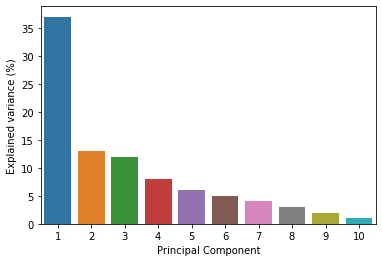

In [10]:
metabolome_analysis.create_scree_plot()

In [11]:
metabolome_analysis.metabolome_pca_reduced.shape

(32, 10)

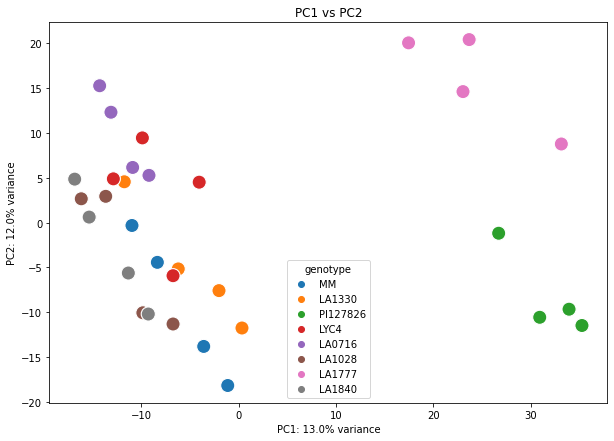

In [12]:
metabolome_analysis.create_sample_score_plot(
    pc_x_axis=1, 
    pc_y_axis=2, 
    name_grouping_var='genotype')

In [13]:
metabolome_analysis.write_clean_metabolome_to_csv(path_of_cleaned_csv="./clean_metabolome.csv")

# Feature selection

In [15]:
fs = MetabolitePhenotypeFeatureSelection(
    metabolome_csv="./clean_metabolome.csv", 
    phenotype_csv="./phenotypes_test_data.csv", 
    phenotype_sample_id='sample')

FileNotFoundError: [Errno 2] No such file or directory: '../../01_data/test_data/phenotypes_test_data.csv'

In [ ]:
fs.validate_input_metabolome_df()

Metabolome data validated.


In [ ]:
fs.validate_input_phenotype_df()

Phenotype data validated.


In [ ]:
fs.get_baseline_performance(scoring_metric='accuracy')

Performing a simple Random Forest model training
N samples: 32
N features: 780
Average accuracy score of the default model is: 0.871 %


In [ ]:
fs.search_best_model(time_left_for_this_task=60)

==== Performance metrics ====
Balanced accuracy: 90.0
Precision score: 83.3
Recall score: 100.0


In [ ]:
fs.automated_ml_obj

AutoSklearnClassifier(metric=balanced_accuracy, per_run_time_limit=6,
                      resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5,
                                                     'train_size': 0.7},
                      scoring_functions=[precision, recall, f1], seed=123,
                      time_left_for_this_task=60)

In [ ]:
fs.automated_ml_obj.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
4,1,0.52,k_nearest_neighbors,0.094697,3.624402
2,2,0.48,random_forest,0.253788,5.120452


In [ ]:
print(fs.automated_ml_obj.sprint_statistics())

auto-sklearn results:
  Dataset name: metabopheno
  Metric: balanced_accuracy
  Best validation score: 0.905303
  Number of target algorithm runs: 9
  Number of successful target algorithm runs: 2
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0



<AxesSubplot:title={'center':'Auto-sklearn accuracy over time'}, xlabel='Timestamp'>

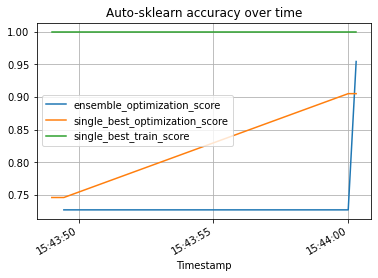

In [ ]:
fs.automated_ml_obj.performance_over_time_.plot(
    x="Timestamp",
    kind="line",
    title="Auto-sklearn accuracy over time",
    grid=True)

In [ ]:
my_X = fs.metabolome.transpose().to_numpy()
my_y = fs.phenotype["phenotype"].to_numpy()

In [ ]:
my_y.shape

(32,)

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    fs.automated_ml_obj, 
    X=my_X, 
    y=my_y, 
    n_repeats=10, 
    scoring='balanced_accuracy')

In [ ]:
feature_importances

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
feature_importances_df = pd.DataFrame.from_dict(feature_importances)
feature_importances_df.set_index(fs.metabolome.index.values, inplace=True)
feature_importances_df.columns = ["permutation_" + str(i+1) for i in range(feature_importances.shape[1])]
feature_importances_df

,permutation_1,permutation_2,permutation_3,permutation_4,permutation_5,permutation_6,permutation_7,permutation_8,permutation_9,permutation_10
rt-0.43_mz-164.97011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-0.43_mz-231.91519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-0.44_mz-147.05014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-0.44_mz-168.61439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-0.44_mz-271.91647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
rt-9.84_mz-413.17812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-9.86_mz-197.08085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-9.88_mz-408.22272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rt-9.8_mz-425.15834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
fs.metabolome

,MM_1,MM_2,MM_3,MM_4,LA1330_1,LA1330_2,LA1330_3,LA1330_4,PI127826_1,PI127826_2,...,LA1028_3,LA1028_4,LA1777_1,LA1777_2,LA1777_3,LA1777_4,LA1840_1,LA1840_2,LA1840_3,LA1840_4
feature_id,,,,,,,,,,,,,,,,,,,,,
rt-0.43_mz-164.97011,866,700,980,1284,1142,1274,976,1442,950,1414,...,784,918,1082,1780,1428,934,1348,536,724,1390
rt-0.43_mz-231.91519,1002,1066,998,1306,1122,1350,990,974,846,770,...,836,978,1170,1016,1426,960,810,818,774,790
rt-0.44_mz-147.05014,898,860,1248,1336,1272,1228,874,1980,984,1072,...,698,1264,952,2112,1570,1132,1044,798,1078,1220
rt-0.44_mz-168.61439,814,828,668,726,660,676,720,622,580,678,...,1274,840,708,668,306,460,998,880,1272,756
rt-0.44_mz-271.91647,1518,2282,1186,1314,1188,1138,1278,778,1830,1448,...,1690,800,1024,628,674,616,1444,1442,1682,1648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rt-9.84_mz-413.17812,54896,19574,58968,16024,6870,67426,5044,62738,33484,31152,...,9352,84442,29626,30406,28614,31022,21076,65556,10574,66584
rt-9.86_mz-197.08085,24652,6620,24582,5928,2650,40312,2100,35250,18524,19672,...,2870,70162,14518,17818,15526,17336,7842,35458,3120,35566
rt-9.88_mz-408.22272,51308,11774,48436,8958,5926,95804,3300,82814,42344,42098,...,3578,167298,36722,40486,34534,39254,9934,71044,5000,67866


In [ ]:
feature_importances_results = [
    feature_importances["importances_mean"],
    feature_importances["importances_std"]
    ]
feature_importances_results_df = pd.DataFrame(feature_importances_results, nam)
feature_importances_results_df

,0,1,2,3,4,5,6,7,8,9,...,770,771,772,773,774,775,776,777,778,779
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
